### Data setup

In [14]:
import os
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

import folder

# folder and data setup
os.chdir(folder.mob_dir)
print(os.listdir())

data = pd.read_csv("MA_cbg2cbg_2019_01.csv", low_memory=False)
print(data.columns)

['countdict.json', 'MA_cbg2cbg_2019_01.csv', 'MA_cbg2cbg_2019_02.csv', 'MA_cbg2cbg_2019_03.csv', 'MA_cbg2cbg_2019_04.csv', 'MA_cbg2cbg_2019_05.csv', 'MA_cbg2cbg_2019_06.csv', 'MA_cbg2cbg_2019_07.csv', 'MA_cbg2cbg_2019_08.csv', 'MA_cbg2cbg_2019_09.csv', 'MA_cbg2cbg_2019_10.csv', 'MA_cbg2cbg_2019_11.csv', 'MA_cbg2cbg_2019_12.csv']
Index(['poi_cbg', 'year_month', 'raw_device_counts', 'visitor_census_tract',
       'visitor_count'],
      dtype='object')


### Q1 Create network

In [15]:
# create network graph
def add_from_mobil_data(df):
    g = nx.Graph()
    data_range = range(len(df))
    for i in data_range:
        a = df.loc[i, "poi_cbg"]
        b = df.loc[i, "visitor_census_tract"]
        flow = df.loc[i, "visitor_count"] / df.loc[i, "raw_device_counts"]
        g.add_edge(a, b, weight = flow)
    print(f"network created: {g}")
    return g

mobil_1901_nw = add_from_mobil_data(data)

network created: Graph with 40292 nodes and 742299 edges


### Q2 Translate network to df

In [16]:
# print table of nodes with degrees and weighted degrees
nodes = list(mobil_1901_nw.nodes)
degree_l = []
w_degree_l = []
for node in nodes:
    degree = mobil_1901_nw.degree(node)
    w_degree = mobil_1901_nw.degree(node, weight="weight")
    degree_l.append(degree)
    w_degree_l.append(w_degree)

node_data = {"node": nodes, "degree": degree_l, "weighted_degree": w_degree_l}
nodes_df = pd.DataFrame(data=node_data)
print(nodes_df.head(), "\n")

           node  degree  weighted_degree
0  250250303003    2936         1.617298
1  250251010016     609         1.829781
2  440070008003      77         0.201907
3  250250923002     600         2.675362
4  250173686001    3217         1.763752 



### Q3 Density graph for weighted degree
The graph shows the network follows a power law distribution for node weighted degree (kde can be less than 0 - graph does not mean we have negative values in data)

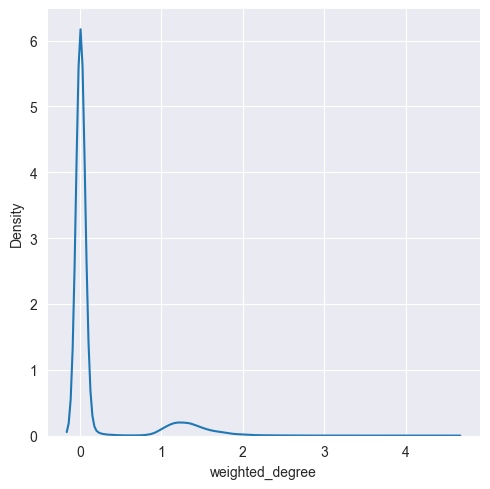

In [17]:
# graph
wd_plot = sns.displot(data=nodes_df.weighted_degree, kind="kde")
plt.savefig(os.path.join(folder.w_dir, "Assignment_10\\node_dist.png"))
plt.show(wd_plot)

### Q4 Testing 6 degrees
The procedure works but only conclusive if the sample data is representative of the original network. Here, the sample is taken at random (a sample of edge from the first data set). Smaller smaple means less edges and interconnections, as the graph below suggests, path lengths can become significantly longer, so this is purely to test the code if it works, but there's good reason to believe that as we increase the sample size, path length distribution will move to the left. We cannot conclude if small world hypothesis applies to the Boston mobility dataset yet, though. Would be cool if we can simulate the Watts and Strogatz's simulation of small world through random rewiring though :)

network created: Graph with 4989 nodes and 5992 edges
sample network created: Graph with 4401 nodes and 5617 edges,
 
8     3754778
9     3456180
7     3109346
10    2555368
6     1896818
11    1601108
5      880958
12     879334
13     427516
4      339694
14     184726
3      117802
15      70176
2       45190
16      23912
1       11190
17       7434
0        4401
18       2172
19        574
20        114
21         10
Name: length, dtype: int64


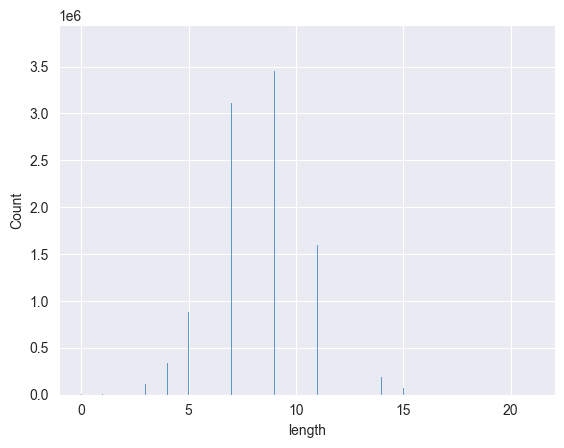

In [20]:
# 6 degrees of separation
# reduce size of data to test by taking an n sample from the original list of edge, then pick out the biggest connected component of that network as a sample
def take_connected_sample(df, size):
    data_sample = df.sample(n=size).reset_index(drop=True)
    temp_graph = add_from_mobil_data(data_sample)
    largest_cc = max(nx.connected_components(temp_graph), key=len)
    sample = temp_graph.subgraph(largest_cc).copy()
    print(f"sample network created: {sample},\n ")
    return sample

# use nx native function to return a nested dict of all lengths between all pairs
# flatten the dict into a list to compile distribution of degrees of separation
# graph distribution
mobil_sample = take_connected_sample(data, 6000)
lengths = dict(nx.all_pairs_shortest_path_length(mobil_sample))
length_df = pd.json_normalize(lengths).T
length_df["length"] = length_df[0]

print(length_df["length"].value_counts())
sep_dist = sns.histplot(data=lengths, x=length_df.length)
plt.show(sep_dist)

#### Note:
Below is another method to get at the same table: First take combination of pair into a list (using itertools), then run through the list to get the list of lengths. Using itertools does not really work with large amount of data due to memory error, however, in which case a manual double loop would work but takes very long (same with nx.all_pairs_shortest_path_length). Not sure how well these tools work with directed network though...


In [19]:
# total_pairs = list(itertools.combinations_with_replacement(nodes, 2))
# d_of_s = []
# for pair in total_pairs:
#     sep = nx.shortest_path_length(mobil_1901_nw, source=pair[0], target=pair[1])
#     d_of_s.append(sep)
#
# tally = pd.DataFrame({"degree_of_separation": d_of_s})
# ds_plot = sns.histplot(data=tally, x=tally.degree_of_separation, kde=True)